In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
past_data_path = os.path.join("..", "data", "processed", "sj_past.csv")
past_data = pd.read_csv(past_data_path).drop(["city"], axis=1)
past_data['week_start_date'] = pd.to_datetime(past_data['week_start_date'])
past_data.set_index('week_start_date', inplace=True)
past_data["T_x_RH"]      = past_data["station_avg_temp_c"] * past_data["dew_humidity"]
past_data["Rain_x_T"]    = past_data["reanalysis_sat_precip_amt_mm"] * past_data["station_avg_temp_c"]
past_data["DTR_x_RH"]    = past_data["station_diur_temp_rng_c"] * past_data["dew_humidity"]

features = past_data.select_dtypes("number").columns.drop(["total_cases","year","weekofyear"])
pass_data_1 = past_data.drop(["total_cases"], axis=1)

In [5]:
lags = 4
for col in features:
    for lag in range(1, lags+1):
        past_data[f'{col}_lag{lag}'] = past_data[col].shift(lag)
past_data.dropna(inplace=True)

In [6]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_past = past_data.drop('total_cases', axis=1).values
y_past = past_data['total_cases'].values.reshape(-1, 1)

X_past_scaled = scaler_X.fit_transform(X_past)
y_past_scaled = scaler_y.fit_transform(y_past)

In [7]:
def create_sequences(X, y, time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps + 1):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps-1])
    return np.array(X_seq), np.array(y_seq)

time_steps = 52
X_past_3d, y_past_3d = create_sequences(X_past_scaled, y_past_scaled, time_steps)

In [8]:
def temporal_split(X, y, train_ratio=0.6, val_ratio=0.2):
    total = len(X)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)
    
    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = temporal_split(X_past_3d, y_past_3d)

In [19]:
model = Sequential()

model.add(Conv1D(
    filters=64,
    kernel_size=16,
    activation='tanh',
    input_shape=(time_steps, X_past_3d.shape[2])
))
model.add(MaxPooling1D(pool_size=2))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.3))

model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

model.compile(optimizer="adam", loss='mae', metrics=['mae'])

c:\Users\13084\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


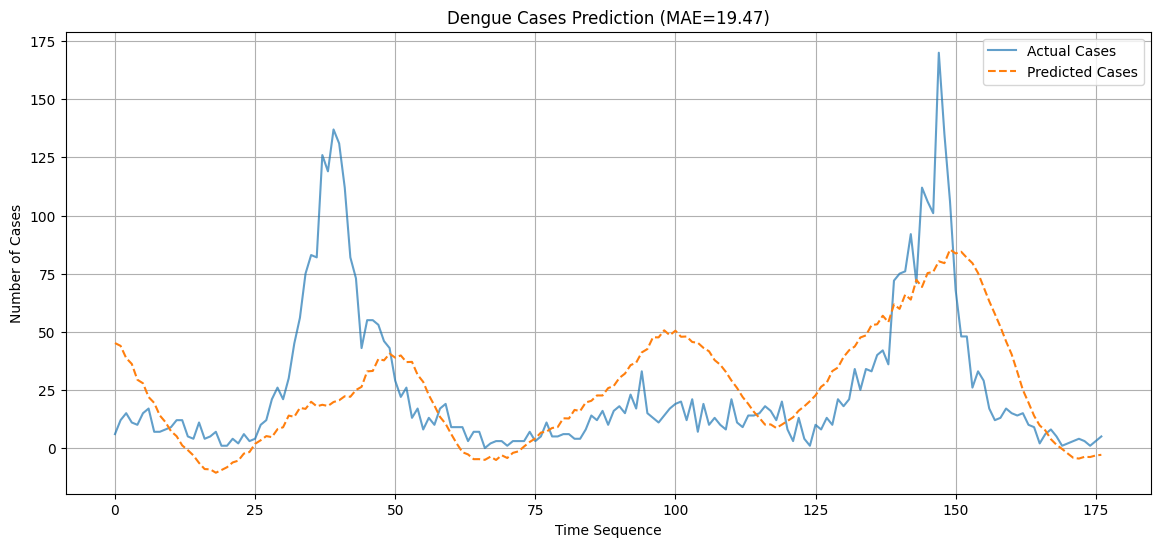

In [20]:
early_stop = EarlyStopping(monitor='val_mae', patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=0
)

test_predict = model.predict(X_test)

y_pred = scaler_y.inverse_transform(test_predict)
y_true = scaler_y.inverse_transform(y_test.reshape(-1,1))

mae = mean_absolute_error(y_true, y_pred)

plt.figure(figsize=(14, 6))
plt.plot(y_true, label="Actual Cases", alpha=0.7)
plt.plot(y_pred, label="Predicted Cases", linestyle='--')
plt.title(f"Dengue Cases Prediction (MAE={mae:.2f})")
plt.xlabel("Time Sequence")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True)
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


C:\Users\13084\AppData\Local\Temp\ipykernel_27352\1775521069.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future_climate[f'{col}_lag{lag}'] = future_climate[col].shift(lag)
C:\Users\13084\AppData\Local\Temp\ipykernel_27352\1775521069.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future_climate[f'{col}_lag{lag}'] = future_climate[col].shift(lag)
C:\Users\13084\AppData\Local\Temp\ipykernel_27352\1775521069.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

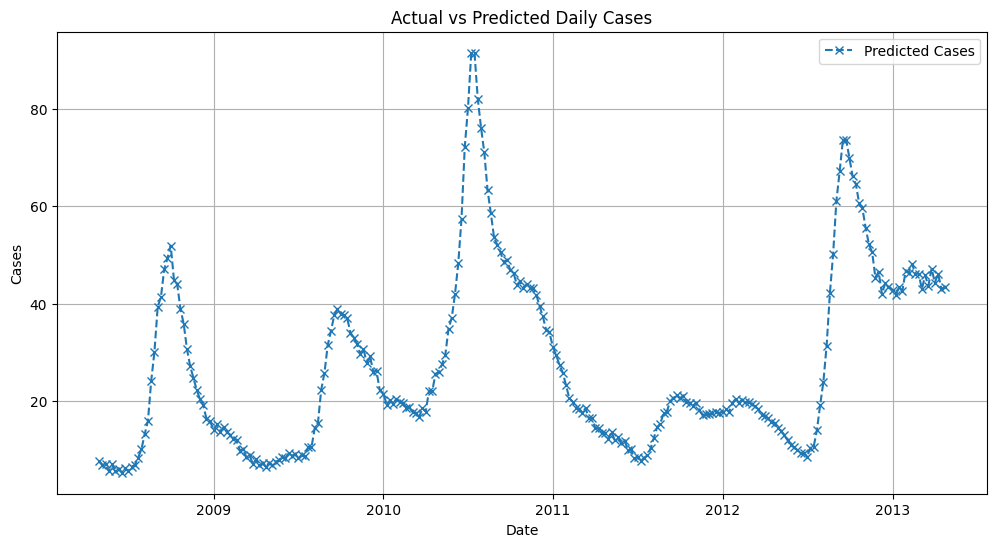

In [16]:
future_climate_path = os.path.join("..", "data", "processed", "sj_future.csv")
future_climate = pd.read_csv(future_climate_path).drop(["city"], axis=1)
future_climate['week_start_date'] = pd.to_datetime(future_climate['week_start_date'])
future_climate.set_index('week_start_date', inplace=True)
future_climate = pd.concat([pass_data_1.tail(51), future_climate], ignore_index=False)
future_climate["T_x_RH"]      = future_climate["station_avg_temp_c"] * future_climate["dew_humidity"]
future_climate["Rain_x_T"]    = future_climate["reanalysis_sat_precip_amt_mm"] * future_climate["station_avg_temp_c"]
future_climate["DTR_x_RH"]    = future_climate["station_diur_temp_rng_c"] * future_climate["dew_humidity"]

for col in features:
    for lag in range(1, lags+1):
        future_climate[f'{col}_lag{lag}'] = future_climate[col].shift(lag)
future_climate.bfill(inplace=True)

X_future = future_climate.values
X_future_scaled = scaler_X.transform(X_future)

X_future_3d, _ = create_sequences(X_future_scaled, np.zeros(len(X_future_scaled)), time_steps)

y_future_scaled = model.predict(X_future_3d)
y_future = scaler_y.inverse_transform(y_future_scaled)

future_dates = future_climate.index[time_steps-1:]

plt.figure(figsize=(12, 6))
plt.plot(future_dates, y_future, label='Predicted Cases', marker='x', linestyle='--')
plt.title("Actual vs Predicted Daily Cases")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.grid(True)
plt.show()

In [2]:
sj_final_model_path = os.path.join("..", "model", "sj_dengue_lstm_model.h5")
sj_final_model = load_model(sj_final_model_path)

6/6 [==============================] - 1s 5ms/step


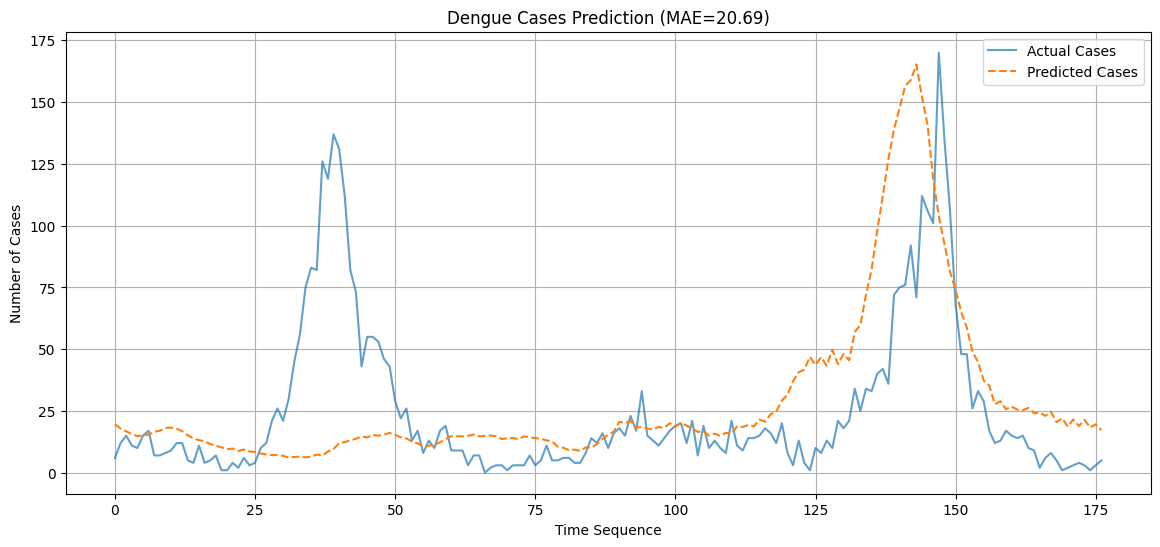

In [9]:
test_predict = sj_final_model.predict(X_test)

y_pred = scaler_y.inverse_transform(test_predict)
y_true = scaler_y.inverse_transform(y_test.reshape(-1,1))

mae = mean_absolute_error(y_true, y_pred)

plt.figure(figsize=(14, 6))
plt.plot(y_true, label="Actual Cases", alpha=0.7)
plt.plot(y_pred, label="Predicted Cases", linestyle='--')
plt.title(f"Dengue Cases Prediction (MAE={mae:.2f})")
plt.xlabel("Time Sequence")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True)
plt.show()

9/9 [==============================] - 0s 5ms/step


C:\Users\13084\AppData\Local\Temp\ipykernel_15592\3366872960.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future_climate[f'{col}_lag{lag}'] = future_climate[col].shift(lag)
C:\Users\13084\AppData\Local\Temp\ipykernel_15592\3366872960.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future_climate[f'{col}_lag{lag}'] = future_climate[col].shift(lag)
C:\Users\13084\AppData\Local\Temp\ipykernel_15592\3366872960.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

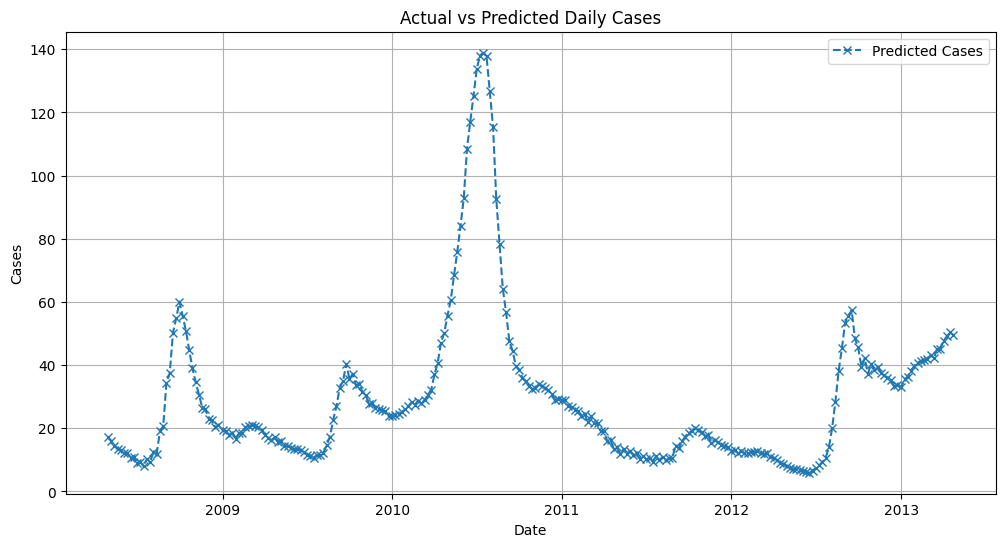

In [10]:
future_climate_path = os.path.join("..", "data", "processed", "sj_future.csv")
future_climate = pd.read_csv(future_climate_path).drop(["city"], axis=1)
future_climate['week_start_date'] = pd.to_datetime(future_climate['week_start_date'])
future_climate.set_index('week_start_date', inplace=True)
future_climate = pd.concat([pass_data_1.tail(51), future_climate], ignore_index=False)
future_climate["T_x_RH"]      = future_climate["station_avg_temp_c"] * future_climate["dew_humidity"]
future_climate["Rain_x_T"]    = future_climate["reanalysis_sat_precip_amt_mm"] * future_climate["station_avg_temp_c"]
future_climate["DTR_x_RH"]    = future_climate["station_diur_temp_rng_c"] * future_climate["dew_humidity"]

for col in features:
    for lag in range(1, lags+1):
        future_climate[f'{col}_lag{lag}'] = future_climate[col].shift(lag)
future_climate.bfill(inplace=True)

X_future = future_climate.values
X_future_scaled = scaler_X.transform(X_future)

X_future_3d, _ = create_sequences(X_future_scaled, np.zeros(len(X_future_scaled)), time_steps)

y_future_scaled = sj_final_model.predict(X_future_3d)
y_future = scaler_y.inverse_transform(y_future_scaled)

future_dates = future_climate.index[time_steps-1:]

plt.figure(figsize=(12, 6))
plt.plot(future_dates, y_future, label='Predicted Cases', marker='x', linestyle='--')
plt.title("Actual vs Predicted Daily Cases")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.grid(True)
plt.show()